# Import libraries, set up paths, and device

This cell imports necessary libraries and defines file paths and device settings.


In [1]:
import os
import cv2
import gc
import json
import torch
import optuna
import datetime
import numpy as np
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import pickle
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torch.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from optuna.storages import RDBStorage
import logging
from pathlib import Path
logging.basicConfig(level=logging.DEBUG)
import sqlite3
from optuna.pruners import MedianPruner
from torch.utils.data import DataLoader
import seaborn as sns
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import torch.nn.functional as F

# Define paths
BASE_DIR = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project")
DATA_DIR = BASE_DIR / "data" / "DAiSEE"
FRAMES_DIR = DATA_DIR / "ExtractedFrames"
LABELS_DIR = DATA_DIR / "Labels"
MODEL_DIR = BASE_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

import os
print("Models directory exists:", os.path.exists("C:/Users/abhis/Downloads/Documents/Learner Engagement Project/models"))
print("Checkpoint path writable:", os.access("C:/Users/abhis/Downloads/Documents/Learner Engagement Project/models", os.W_OK))
os.makedirs("C:/Users/abhis/Downloads/Documents/Learner Engagement Project/models", exist_ok=True)

# Set environment variables
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # for better error traces 

# Precomputed directory for caching best frames
CACHE_DIR = BASE_DIR / "cache"
CACHE_DIR.mkdir(exist_ok=True)

torch.backends.cudnn.benchmark = True  # Optimize cuDNN
torch.backends.cuda.matmul.allow_tf32 = True  # Allow TensorFloat-32

# Set device and CUDA configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define data transforms for training and validation.
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Models directory exists: True
Checkpoint path writable: True
Using device: cuda


# Define helper function for selecting 30 best frames using face detection and sharpness

This cell defines a function that, given a folder of extracted frames, divides them into 30 equal temporal segments and selects the best frame from each segment based on face detection and sharpness.


In [2]:
# Mapping CSV clip IDs.
def get_csv_clip_id(video_stem: str) -> str:
    base = video_stem.strip()
    if base.startswith("110001"):
        base = base.replace("110001", "202614", 1)
    return base

# Select best frames using face detection and Laplacian variance.
def select_impactful_frames(video_folder: Path, num_frames=30):
    frame_files = sorted(video_folder.glob("frame_*.jpg"))
    total_frames = len(frame_files)
    if total_frames == 0:
        return []
    if total_frames <= num_frames:
        return frame_files
    segment_size = total_frames // num_frames
    cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    face_cascade = cv2.CascadeClassifier(cascade_path)
    selected_frames = []
    for i in range(num_frames):
        start_idx = i * segment_size
        end_idx = (i + 1) * segment_size if i < num_frames - 1 else total_frames
        best_score = -1
        best_frame = None
        for fp in frame_files[start_idx:end_idx]:
            img = cv2.imread(str(fp))
            if img is None:
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
            if len(faces) > 0:
                face = max(faces, key=lambda r: r[2]*r[3])
                x, y, w, h = face
                region = gray[y:y+h, x:x+w]
                quality = cv2.Laplacian(region, cv2.CV_64F).var()
            else:
                quality = cv2.Laplacian(gray, cv2.CV_64F).var()
            if quality > best_score:
                best_score = quality
                best_frame = fp
        if best_frame is not None:
            selected_frames.append(best_frame)
    return selected_frames

def precompute_best_frames(csv_file: Path, video_root: Path, num_frames=30):
    """
    Precompute and cache the best frame paths for each video in the CSV.
    The results are saved to a pickle file and returned.
    """
    data = pd.read_csv(csv_file, dtype=str)
    data.columns = data.columns.str.strip()
    split = Path(csv_file).stem.replace("Labels", "").strip()
    precomputed = []
    valid_indices = []
    skipped_count = 0

    for idx, row in tqdm(data.iterrows(), total=len(data), desc="Precomputing best frames", dynamic_ncols=True):
        clip_id = str(row["ClipID"]).strip()
        if clip_id.endswith(('.avi', '.mp4')):
            clip_id = clip_id.rsplit('.', 1)[0]
        mapped_id = get_csv_clip_id(clip_id)
        video_folder = video_root / split / mapped_id
        if video_folder.exists():
            frame_files = sorted(video_folder.glob("frame_*.jpg"))
            if len(frame_files) >= num_frames:
                selected_frames = select_impactful_frames(video_folder, num_frames)
                precomputed.append(selected_frames)
                valid_indices.append(idx)
            else:
                skipped_count += 1
        else:
            skipped_count += 1
    print(f"Precomputation: Skipped {skipped_count} videos out of {len(data)}.")
    cache_data = {"valid_indices": valid_indices, "precomputed_frames": precomputed}
    cache_file = CACHE_DIR / f"precomputed_{Path(csv_file).stem}_frame_{num_frames}.pkl"
    with open(cache_file, "wb") as f:
        pickle.dump(cache_data, f)
    print(f"Precomputed results saved to {cache_file}")
    return cache_data

# Define the custom Dataset for video classification

This cell defines a PyTorch Dataset that reads a CSV file with video IDs and 4 labels. For each video, it loads the 30 best frames using the above function, applies transforms, and returns a tensor and its label.


In [3]:
# Define the custom Dataset for video classification
class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, video_root, transform=None, num_frames=30):
        self.cache = {}
        self.max_cache_size = 400
        self.cache_order = []
        self.csv_file = Path(csv_file)
        self.data = pd.read_csv(self.csv_file, dtype=str)
        self.data.columns = self.data.columns.str.strip()
        self.video_root = Path(video_root)
        self.transform = transform
        self.num_frames = num_frames
        self.split = self.csv_file.stem.replace("Labels", "").strip()
        cache_file = CACHE_DIR / f"precomputed_{Path(csv_file).stem}_frame_{num_frames}.pkl"
        if cache_file.exists():
            with open(cache_file, "rb") as f:
                cache_data = pickle.load(f)
            valid_indices = cache_data["valid_indices"]
            self.precomputed_frames = cache_data["precomputed_frames"]
            self.data = self.data.iloc[valid_indices].reset_index(drop=True)
            print(f"Loaded precomputed frames for {len(self.data)} videos from cache.")
        else:
            valid_rows = []
            self.precomputed_frames = []
            skipped_count = 0
            for idx, row in self.data.iterrows():
                clip_id = str(row["ClipID"]).strip()
                if clip_id.endswith(('.avi', '.mp4')):
                    clip_id = clip_id.rsplit('.', 1)[0]
                mapped_id = get_csv_clip_id(clip_id)
                video_folder = self.video_root / self.split / mapped_id
                if video_folder.exists():
                    frame_files = sorted(video_folder.glob("frame_*.jpg"))
                    if len(frame_files) >= num_frames:
                        selected_frames = select_impactful_frames(video_folder, num_frames)
                        valid_rows.append(row)
                        self.precomputed_frames.append(selected_frames)
                    else:
                        skipped_count += 1
                else:
                    skipped_count += 1
            self.data = pd.DataFrame(valid_rows)
            print(f"Computed frames on the fly: Skipped {skipped_count} videos.")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Check cache first
        if idx in self.cache:
            self.cache_order.remove(idx)
            self.cache_order.append(idx)
            cached_frames, labels = self.cache[idx]
            return cached_frames.clone(), labels.clone()
        
        row = self.data.iloc[idx]
        selected_frame_paths = self.precomputed_frames[idx]
        
        raw_images = []
        for fp in selected_frame_paths:
            try:
                img = Image.open(fp).convert("RGB")
            except (FileNotFoundError, OSError):
                img = Image.new('RGB', (224, 224))
            raw_images.append(img)
        
        while len(raw_images) < self.num_frames:
            raw_images.append(Image.new('RGB', (224, 224)))
        
        transformed_frames = [self.transform(img) for img in raw_images]
        
        frames_tensor = torch.stack(transformed_frames)
        labels = torch.tensor([
            int(row["Engagement"]),
            int(row["Boredom"]),
            int(row["Confusion"]),
            int(row["Frustration"])
        ], dtype=torch.long)
        
        # Cache only if not using random transforms (validation/test)
        if not isinstance(self.transform, transforms.Compose) or \
           not any(isinstance(t, transforms.RandomHorizontalFlip) for t in self.transform.transforms):
            self.cache[idx] = (frames_tensor.cpu(), labels.cpu())
        
        if not isinstance(self.transform, transforms.Compose) or \
           not any(isinstance(t, transforms.RandomHorizontalFlip) for t in self.transform.transforms):
            if len(self.cache) >= self.max_cache_size:
                oldest_idx = self.cache_order.pop(0)
                del self.cache[oldest_idx]
            self.cache[idx] = (frames_tensor.cpu(), labels.cpu())
            self.cache_order.append(idx)
        
        return frames_tensor, labels

# Define the MobileNetV2-TCN model

This cell defines the MobileNetV2-TCN model. It processes a sequence of frames by applying MobileNetV2 on each frame, stacking the features, and feeding them to a temporal convolution network (TCN).


In [4]:
# Define the MobileNetV2-TCN model
class MobileNetTCN(nn.Module):
    def __init__(self, hidden_ch=128, freeze_block=0):
        super(MobileNetTCN, self).__init__()
        self.mobilenet = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        self.freeze_blocks(freeze_block)
        self.mobilenet.classifier = nn.Identity()
        
        # Adjust TCN layers using hyperparameter hidden_ch.
        self.tcn = nn.Sequential(
            nn.Conv1d(1280, hidden_ch, kernel_size=3, dilation=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_ch, 16, kernel_size=1)
        )
    
    def freeze_blocks(self, freeze_block):
        # Freeze the first 'freeze_block' blocks in MobileNetV2 features.
        if freeze_block > 0:
            for i in range(freeze_block):
                if i < len(self.mobilenet.features):
                    for param in self.mobilenet.features[i].parameters():
                        param.requires_grad = False
    
    def forward(self, x):
        batch_size, num_frames, C, H, W = x.size()
        x_reshaped = x.view(-1, C, H, W)
        features_reshaped = self.mobilenet(x_reshaped)
        features = features_reshaped.view(batch_size, num_frames, -1).permute(0, 2, 1)
        out = self.tcn(features)
        out = out[:, :, -1]
        return out

# Define training, checkpointing, and evaluation functions

This cell defines the training loop which uses mixed precision (`torch.cuda.amp`), shows progress with `tqdm`, and saves checkpoints to resume training.


In [5]:
# Define training, checkpointing, and evaluation functions
def save_checkpoint(model, optimizer, epoch, best_val_loss, checkpoint_path):
    try:
        print(f"Saving checkpoint to {checkpoint_path} ...")  # Debugging print
        state = {
            "epoch": epoch,
            "best_val_loss": best_val_loss,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()
        }
        temp_path = checkpoint_path.with_suffix(".tmp")
        torch.save(state, temp_path)
        
        # Remove existing file if it exists
        if checkpoint_path.exists():
            checkpoint_path.unlink()
            
        # Rename temp file
        temp_path.rename(checkpoint_path)
        
        print(f"Checkpoint saved successfully to {checkpoint_path}")
    except Exception as e:
        print(f"Error saving checkpoint: {e}")
        # Clean up temp file if it exists
        if temp_path.exists():
            temp_path.unlink()
        raise

def load_checkpoint(model, optimizer, checkpoint_path):
    if checkpoint_path.exists():
        try:
            state = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(state["model_state_dict"])
            optimizer.load_state_dict(state["optimizer_state_dict"])
            return state["epoch"], state["best_val_loss"]
        except:
            print(f"Error loading checkpoint {checkpoint_path}, starting from scratch")
            return 0, float("inf")
    return 0, float("inf")

def train_model(model, train_loader, val_loader, epochs, lr, checkpoint_path, patience=5, gradient_accum_steps=8):
    model.to(device, non_blocking=True)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scaler = GradScaler()
    start_epoch, best_val_loss = load_checkpoint(model, optimizer, checkpoint_path)
    loss_fn = nn.CrossEntropyLoss().to(device)
    early_stop_counter = 0
    
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    checkpoint_path.parent.mkdir(parents=True, exist_ok=True)

    for epoch in range(start_epoch, epochs):
        model.train()
        running_loss = 0.0

        for i, (frames, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]")):
            # Use non_blocking=True 
            frames = frames.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with autocast(enabled=True, dtype=torch.float16, device_type='cuda'):
                outputs = model(frames)
                outputs_reshaped = outputs.view(outputs.size(0), 4, 4)
                loss = sum(loss_fn(outputs_reshaped[:, d], labels[:, d]) for d in range(4)) / 4.0

            scaler.scale(loss / gradient_accum_steps).backward()
            if (i + 1) % gradient_accum_steps == 0:
                scaler.step(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item() * frames.size(0)
            
            del frames, labels, outputs, outputs_reshaped, loss
            if (i + 1) % 30 == 0:
                torch.cuda.empty_cache()
                gc.collect()

        train_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad(), autocast(enabled=True, dtype=torch.float16, device_type='cuda'):
            for frames, labels in val_loader:
                # Fix non_blocking and memory_format
                frames = frames.to(device, non_blocking=True).half()
                labels = labels.to(device, non_blocking=True)
                outputs = model(frames)
                outputs_reshaped = outputs.view(outputs.size(0), 4, 4)
                loss = sum(loss_fn(outputs_reshaped[:, d], labels[:, d]) for d in range(4)) / 4.0
                val_loss += loss.item() * frames.size(0)

        val_loss /= len(val_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_checkpoint(model, optimizer, epoch + 1, best_val_loss, checkpoint_path)
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best loss: {best_val_loss:.4f}")
            break

    return best_val_loss

# Define the Optuna objective for hyperparameter tuning (using SQLite storage)

This cell defines an Optuna objective that trains the MobileNetV2-TCN model for a few epochs using hyperparameters suggested by the trial. The study is configured to use an SQLite database (`tuning.db`) for saving progress so tuning can be resumed.


In [6]:
# Define the Optuna objective for hyperparameter tuning (using SQLite storage)
def objective(trial):
    num_frames = trial.suggest_categorical("num_frames", [30])
    batch_size = trial.suggest_categorical("batch_size", [4, 8])
    lr = trial.suggest_float("lr", 1e-5, 5e-4, log=True)
    epochs = trial.suggest_int("epochs", 3, 5)
    hidden_ch = trial.suggest_categorical("hidden_ch", [64, 128])
    freeze_block = trial.suggest_int("freeze_block", 0, 4)

    from torch.utils.data import DataLoader
    train_dataset = VideoDataset(LABELS_DIR / "TrainLabels.csv", FRAMES_DIR, transform=train_transform, num_frames=num_frames)
    val_dataset = VideoDataset(LABELS_DIR / "ValidationLabels.csv", FRAMES_DIR, transform=val_transform, num_frames=num_frames)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True, persistent_workers=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=3, pin_memory=True, persistent_workers=False)

    model = MobileNetTCN(hidden_ch=hidden_ch, freeze_block=freeze_block)
    
    trial_checkpoint = MODEL_DIR / f"checkpoint_trial_{trial.number}.pth"
    trial_checkpoint.parent.mkdir(parents=True, exist_ok=True)

    try:
        best_val_loss = train_model(model, train_loader, val_loader, epochs, lr, trial_checkpoint, patience=3)
        if not trial_checkpoint.exists():
            print(f"Trial {trial.number} failed to save checkpoint!")
            return float("inf")
        return best_val_loss
        
    except Exception as e:
        if trial_checkpoint.exists():
            trial_checkpoint.unlink()
        print(f"Trial {trial.number} failed: {e}")
        return float("inf")
    

# Evaluate and visualize results

This cell evaluates the final model on the test set and prints a classification report.


In [16]:
def evaluate_model(model, test_loader):
    model.eval()
    batch_all_preds = []
    batch_all_labels = []
    total_batches = len(test_loader)
    
    # Target class distributions from the training set (adjusted for better balance)
    target_distributions = {
        0: [0.005, 0.055, 0.510, 0.430],  # Engagement - increased class 0,1 
        1: [0.456, 0.317, 0.204, 0.023],  # Boredom
        2: [0.693, 0.225, 0.071, 0.011],  # Confusion
        3: [0.781, 0.171, 0.034, 0.014]   # Frustration
    }
    
    # Enhanced temperature scaling factors (higher = softer probabilities)
    temperatures = [1.9, 1.7, 3.8, 4.0]  # Increased for better minority class detection
    
    with torch.no_grad(), autocast(enabled=True, dtype=torch.float16, device_type='cuda'):
        for frames, labels in tqdm(test_loader, desc="Evaluating", total=total_batches, dynamic_ncols=True):
            frames = frames.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(frames)
            outputs_reshaped = outputs.view(outputs.size(0), 4, 4)
            
            # Store raw logits for post-processing
            batch_all_labels.append(labels.cpu())
            batch_logits = outputs_reshaped.cpu()
            batch_all_preds.append(batch_logits)
        
        # Process all batches together for better statistics
        all_labels = torch.cat(batch_all_labels, dim=0).numpy()
        all_logits = torch.cat(batch_all_preds, dim=0)
        
        # Process each emotion separately with enhanced temperature scaling and distribution matching
        final_preds = torch.zeros_like(all_logits[:, :, 0], dtype=torch.long)
        
        for i, emotion in enumerate(["Engagement", "Boredom", "Confusion", "Frustration"]):
            # Apply temperature scaling
            scaled_logits = all_logits[:, i] / temperatures[i]
            probs = F.softmax(scaled_logits, dim=1)
            
            # Specialized handling for Engagement (low classes severely underrepresented)
            if i == 0:  # Engagement
                raw_preds = torch.argmax(probs, dim=1)
                
                # Enhanced minority class detection - specifically target classes 0 and 1
                # Identify potential class 0,1 candidates (those with non-negligible probabilities)
                class0_candidates = (probs[:, 0] > 0.12)
                class1_candidates = (probs[:, 1] > 0.18)
                minority_candidates = class0_candidates | class1_candidates
                
                # For these candidates, boost class 0,1 probabilities
                if minority_candidates.sum() > 0:
                    adjusted_probs = probs[minority_candidates].clone()
                    adjusted_probs[:, 0] *= 2.1  # Stronger boost for extremely rare class 0
                    adjusted_probs[:, 1] *= 1.75  # Boost for class 1
                    
                    # Re-normalize
                    adjusted_probs = adjusted_probs / adjusted_probs.sum(dim=1, keepdim=True)
                    
                    # Get new predictions
                    minority_preds = torch.argmax(adjusted_probs, dim=1)
                    
                    # Apply these predictions back
                    raw_preds[minority_candidates] = minority_preds
                
                # Apply distribution matching on remaining class 2 predictions
                class2_indices = (raw_preds == 2).nonzero(as_tuple=True)[0]
                
                # Calculate how many should be reassigned to match distribution
                current_dist = torch.bincount(raw_preds, minlength=4) / len(raw_preds)
                target_dist = torch.tensor(target_distributions[i])
                
                # How many class 2 instances to reassign to other classes (avoid negative numbers)
                to_reassign = {
                    0: max(0, int(len(raw_preds) * (target_dist[0] - current_dist[0]))),
                    1: max(0, int(len(raw_preds) * (target_dist[1] - current_dist[1]))),
                    3: max(0, int(len(raw_preds) * (target_dist[3] - current_dist[3])))
                }
                
                # Choose samples to reassign based on probability ratios
                if len(class2_indices) > 0:
                    class2_probs = probs[class2_indices]
                    # Use probability ratio as a measure of confidence
                    class2_ratios = class2_probs[:, 2] / (class2_probs[:, 0] + class2_probs[:, 1] + class2_probs[:, 3] + 1e-8)
                    sorted_ratio_indices = torch.argsort(class2_ratios)
                    
                    # Assign to class 0 and 1 (rare classes)
                    if to_reassign[0] > 0 and to_reassign[0] < len(class2_indices):
                        indices_for_0 = class2_indices[sorted_ratio_indices[:to_reassign[0]]]
                        raw_preds[indices_for_0] = 0
                    
                    if to_reassign[1] > 0 and to_reassign[1] < len(class2_indices) - to_reassign[0]:
                        start = min(to_reassign[0], len(sorted_ratio_indices)-1)
                        end = min(to_reassign[0] + to_reassign[1], len(sorted_ratio_indices))
                        indices_for_1 = class2_indices[sorted_ratio_indices[start:end]]
                        raw_preds[indices_for_1] = 1
                
                # The rest remain as predicted
                final_preds[:, i] = raw_preds
                
            # For severely collapsed categories (Confusion & Frustration)
            elif i in [2, 3]:
                # Use enhanced distribution matching for collapsed categories
                confidences = probs.max(dim=1)[0]
                sorted_indices = torch.argsort(confidences)
                
                # Calculate how many samples should be in each class
                n_samples = len(probs)
                class_counts = [int(n_samples * target_distributions[i][c]) for c in range(4)]
                # Adjust the last class to ensure we use all samples
                class_counts[3] = n_samples - sum(class_counts[:3])
                
                # Assign classes based on confidence ranking
                pred_classes = torch.zeros(n_samples, dtype=torch.long)
                start_idx = 0
                for class_idx in range(4):
                    end_idx = start_idx + class_counts[class_idx]
                    pred_classes[sorted_indices[start_idx:end_idx]] = class_idx
                    start_idx = end_idx
                
                final_preds[:, i] = pred_classes
                
            else:  # Boredom - moderate collapse
                # Get argmax predictions
                preds = torch.argmax(probs, dim=1)
                
                # Adjust class distribution for boredom
                class0_indices = (preds == 0).nonzero(as_tuple=True)[0]
                
                # Calculate adjustments needed
                current_dist = torch.bincount(preds, minlength=4) / len(preds)
                target_dist = torch.tensor(target_distributions[i])
                
                # How many to reassign from class 0
                to_reassign = {
                    1: max(0, int(len(preds) * (target_dist[1] - current_dist[1]))),
                    2: max(0, int(len(preds) * (target_dist[2] - current_dist[2]))),
                    3: max(0, int(len(preds) * (target_dist[3] - current_dist[3])))
                }
                
                # Choose which samples to reassign based on class 0 vs class 1 probability ratio
                if len(class0_indices) > 0:
                    class0_probs = probs[class0_indices]
                    class0_1_ratios = class0_probs[:, 0] / (class0_probs[:, 1] + 1e-8)
                    sorted_ratio_indices = torch.argsort(class0_1_ratios)
                    
                    # Assign to classes 1, 2, 3
                    if to_reassign[1] > 0 and to_reassign[1] < len(class0_indices):
                        indices_for_1 = class0_indices[sorted_ratio_indices[:to_reassign[1]]]
                        preds[indices_for_1] = 1
                    
                    if to_reassign[2] > 0 and to_reassign[2] < len(class0_indices) - to_reassign[1]:
                        start = min(to_reassign[1], len(sorted_ratio_indices)-1)
                        end = min(to_reassign[1] + to_reassign[2], len(sorted_ratio_indices))
                        indices_for_2 = class0_indices[sorted_ratio_indices[start:end]]
                        preds[indices_for_2] = 2
                    
                    if to_reassign[3] > 0 and to_reassign[3] < len(class0_indices) - to_reassign[1] - to_reassign[2]:
                        start = min(to_reassign[1] + to_reassign[2], len(sorted_ratio_indices)-1)
                        end = min(to_reassign[1] + to_reassign[2] + to_reassign[3], len(sorted_ratio_indices))
                        indices_for_3 = class0_indices[sorted_ratio_indices[start:end]]
                        preds[indices_for_3] = 3
                    
                final_preds[:, i] = preds
    
    all_preds = final_preds.numpy()
    
    # Continue with evaluation code - metrics calculation and visualization
    results = {}
    metrics = ["Engagement", "Boredom", "Confusion", "Frustration"]
    
    for i, metric in enumerate(metrics):
        print(f"\nEvaluating model for {metric}...")
        
        # Calculate accuracy
        acc = accuracy_score(all_labels[:, i], all_preds[:, i])
        results[metric] = acc
        print(f"{metric} validation accuracy: {acc:.4f}")
        
        # Print classification report
        print("\nClassification Report:")
        report = classification_report(all_labels[:, i], all_preds[:, i])
        print(report)
        
        # Print confusion matrix
        cm = confusion_matrix(all_labels[:, i], all_preds[:, i])
        print("Confusion Matrix:")
        print(cm)
        
        # --- Visualizations ---
        
        # 1. Confusion Matrix Heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"{metric} - Confusion Matrix")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels") 
        plt.tight_layout()
        plt.savefig(f"{metric}_confusion_matrix.png", dpi=300)
        plt.show()
        
        # 2. Bar Chart for Label Distribution
        true_counts = Counter(all_labels[:, i])
        pred_counts = Counter(all_preds[:, i])
        
        labels = sorted(set(np.concatenate([all_labels[:, i], all_preds[:, i]])))
        true_vals = [true_counts.get(label, 0) for label in labels]
        pred_vals = [pred_counts.get(label, 0) for label in labels]
        
        plt.figure(figsize=(8, 4))
        width = 0.35
        x = np.arange(len(labels))
        plt.bar(x - width/2, true_vals, width, label="True Labels")
        plt.bar(x + width/2, pred_vals, width, label="Predicted Labels")
        plt.xlabel("Label")
        plt.ylabel("Count")
        plt.title(f"{metric} - Distribution of True vs Predicted Labels")
        plt.xticks(x, labels)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{metric}_label_distribution.png", dpi=300)
        plt.show()
    
    # Print summary of results
    print("\n--- Performance Summary ---")
    for metric, acc in results.items():
        print(f"{metric}: {acc:.4f}")
    
    return results


--- Skipping Final Training (Checkpoint Exists) ---
Using existing model from: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\models\final_model_checkpoint.pth

--- Starting Evaluation ---
Loaded precomputed frames for 1638 videos from cache.


Evaluating: 100%|██████████| 205/205 [04:52<00:00,  1.43s/it]



Evaluating model for Engagement...
Engagement validation accuracy: 0.4274

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.14      0.16      0.15        81
           2       0.50      0.37      0.43       849
           3       0.41      0.52      0.46       704

    accuracy                           0.43      1638
   macro avg       0.26      0.26      0.26      1638
weighted avg       0.44      0.43      0.43      1638

Confusion Matrix:
[[  0   1   2   1]
 [  2  13  24  42]
 [  4  29 318 498]
 [  2  47 286 369]]


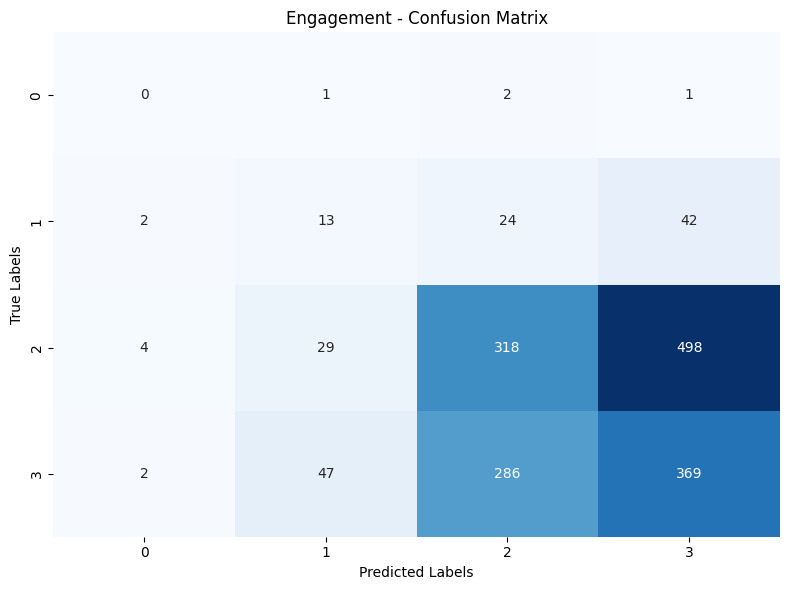

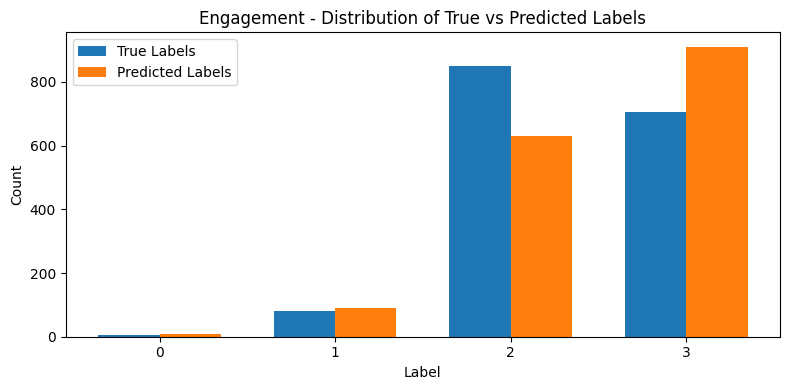


Evaluating model for Boredom...
Boredom validation accuracy: 0.3871

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50       747
           1       0.35      0.35      0.35       519
           2       0.24      0.24      0.24       335
           3       0.03      0.03      0.03        37

    accuracy                           0.39      1638
   macro avg       0.28      0.28      0.28      1638
weighted avg       0.39      0.39      0.39      1638

Confusion Matrix:
[[373 210 146  18]
 [229 180  97  13]
 [137 113  80   5]
 [  9  16  11   1]]


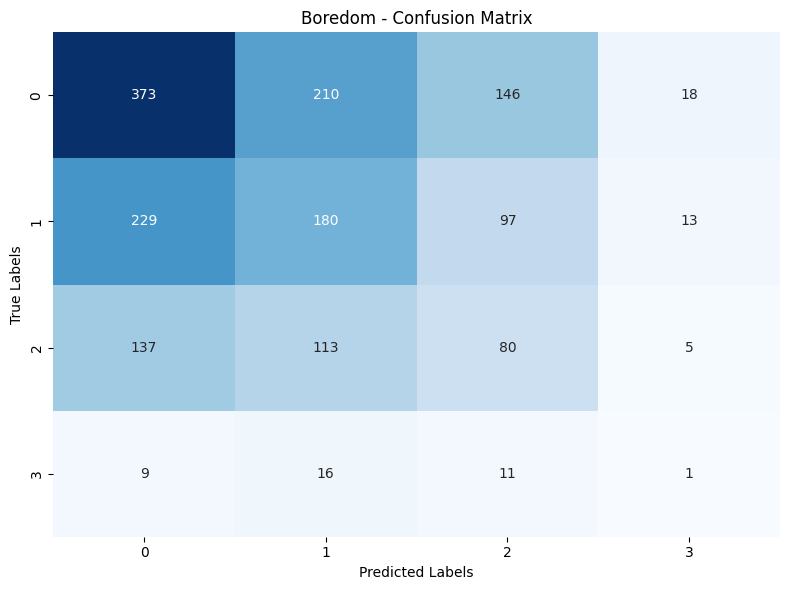

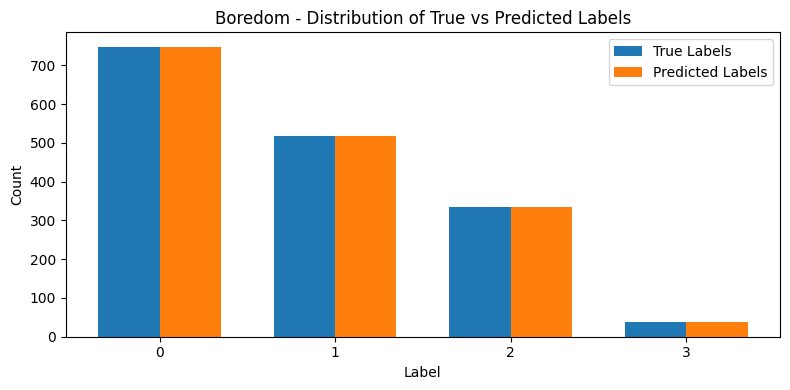


Evaluating model for Confusion...
Confusion validation accuracy: 0.5397

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      1135
           1       0.23      0.23      0.23       368
           2       0.06      0.06      0.06       116
           3       0.00      0.00      0.00        19

    accuracy                           0.54      1638
   macro avg       0.25      0.25      0.25      1638
weighted avg       0.54      0.54      0.54      1638

Confusion Matrix:
[[791 252  80  12]
 [247  86  29   6]
 [ 81  27   7   1]
 [ 16   3   0   0]]


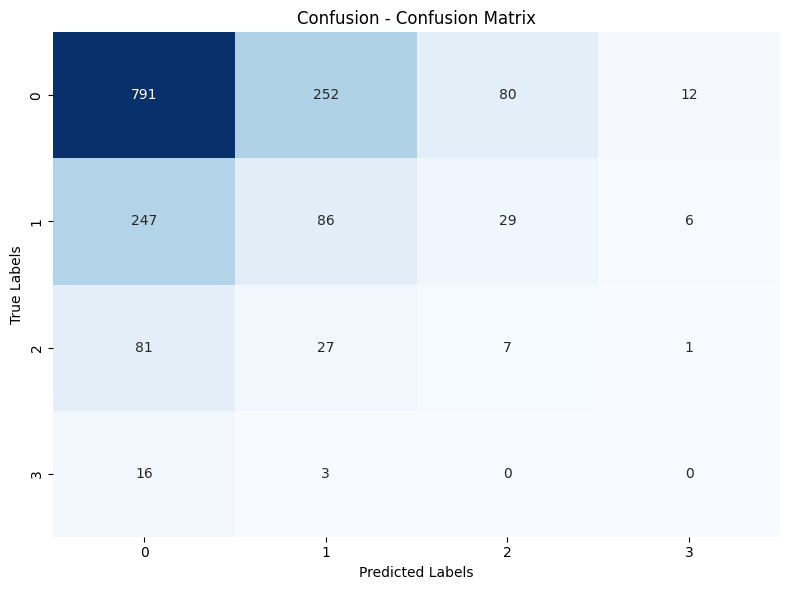

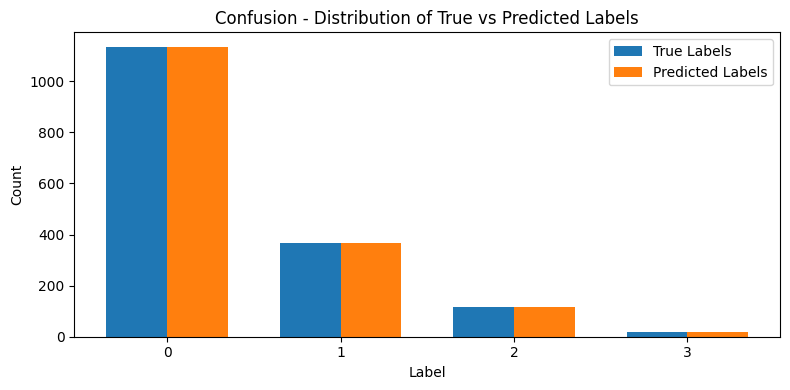


Evaluating model for Frustration...
Frustration validation accuracy: 0.6245

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1279
           1       0.14      0.14      0.14       280
           2       0.00      0.00      0.00        56
           3       0.00      0.00      0.00        23

    accuracy                           0.62      1638
   macro avg       0.23      0.23      0.23      1638
weighted avg       0.62      0.62      0.62      1638

Confusion Matrix:
[[983 231  47  18]
 [228  40   7   5]
 [ 48   7   0   1]
 [ 20   2   1   0]]


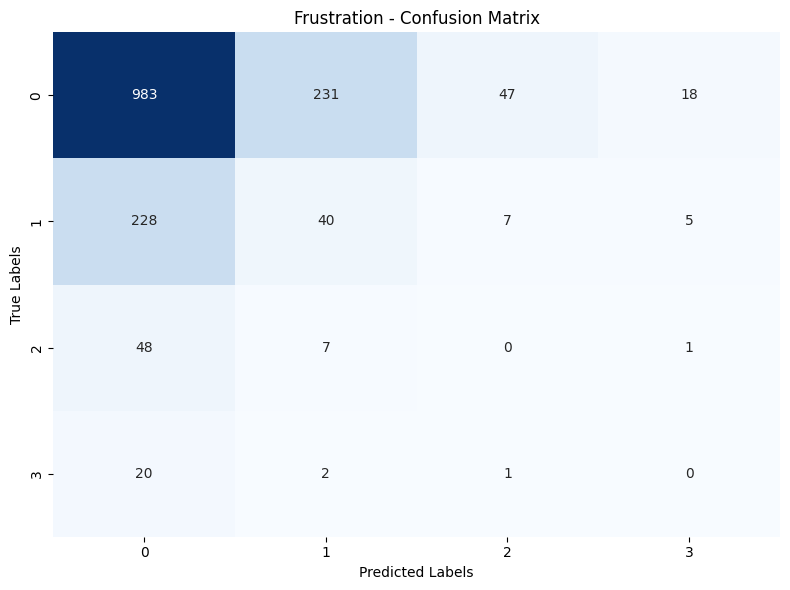

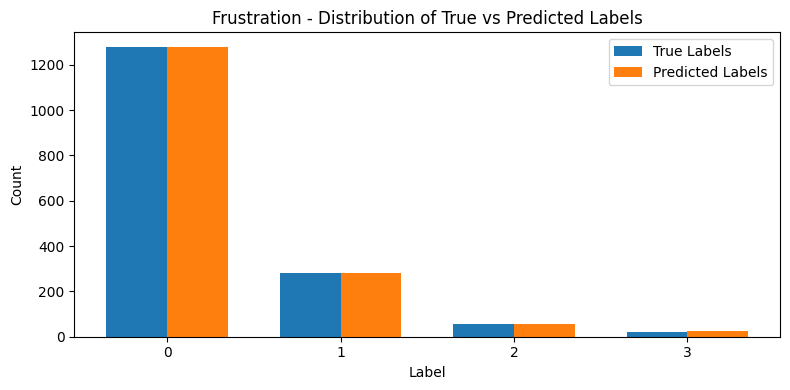


--- Performance Summary ---
Engagement: 0.4274
Boredom: 0.3871
Confusion: 0.5397
Frustration: 0.6245

--- Evaluation Complete ---


In [17]:
# Step 3: Final training with best hyperparameters and early stopping
final_checkpoint = MODEL_DIR / "final_model_checkpoint.pth"

if not final_checkpoint.exists():
    print("\n--- Starting Final Training ---")
    best_trial = study.best_trial
    params = best_trial.params

    num_frames = params.get("num_frames", 30)
    batch_size = params.get("batch_size", 8)
    lr = params.get("lr", 1e-4)
    epochs = params.get("epochs", 5)
    hidden_ch = params.get("hidden_ch", 128)
    freeze_block = params.get("freeze_block", 3)

    train_dataset = VideoDataset(train_csv, FRAMES_DIR, 
                                transform=train_transform, 
                                num_frames=num_frames)
    val_dataset = VideoDataset(val_csv, FRAMES_DIR,
                              transform=val_transform,
                              num_frames=num_frames)

    loader_args = {
        'batch_size': batch_size,
        'num_workers': 3,       # or 1
        'pin_memory': False,    # disable pinned memory on Windows
        'persistent_workers': False,
        'prefetch_factor': 2
    }

    train_loader = DataLoader(train_dataset, shuffle=True, **loader_args)
    val_loader = DataLoader(val_dataset, shuffle=False, **loader_args)

    final_model = MobileNetTCN(hidden_ch=hidden_ch, freeze_block=freeze_block)
    
    print(f"Training with: batch_size={batch_size}, lr={lr:.0e}, "
          f"hidden_ch={hidden_ch}, freeze_block={freeze_block}")
    try:
        train_model(final_model, train_loader, val_loader, 
                   epochs, lr, final_checkpoint, patience=5)
    except RuntimeError as e:
        print(f"Training failed: {e}")
        if final_checkpoint.exists():
            print("Partial checkpoint may exist")
            exit(1)
        if 'CUDA out of memory' in str(e):
            print("\nERROR: Insufficient GPU memory for final training!")
            print("Try reducing batch_size or hidden_ch in best parameters")
            exit(1)
        else:
            raise

    if not final_checkpoint.exists():
        print("ERROR: Final checkpoint not created after training!")
        exit(1)
else:
    print("\n--- Skipping Final Training (Checkpoint Exists) ---")
    print(f"Using existing model from: {final_checkpoint}")

print("\n--- Starting Evaluation ---")

if 'best_trial' not in locals():
    best_trial = study.best_trial
    params = best_trial.params
    num_frames = params.get("num_frames", 30)
    batch_size = params.get("batch_size", 8)
    hidden_ch = params.get("hidden_ch", 128)
    freeze_block = params.get("freeze_block", 3)
    epochs = params.get("epochs", 5)
    lr = params.get("lr", 0.00021151843688232635)

eval_model = MobileNetTCN(hidden_ch=hidden_ch, freeze_block=freeze_block)
if final_checkpoint.exists():
    state = torch.load(final_checkpoint, map_location=device)
    eval_model.load_state_dict(state['model_state_dict'])
else:
    raise FileNotFoundError(f"No checkpoint found at {final_checkpoint}")

eval_model.to(device)

test_csv = LABELS_DIR / "TestLabels.csv"
test_dataset = VideoDataset(test_csv, FRAMES_DIR,
                           transform=val_transform,
                           num_frames=num_frames)

test_loader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=0,
                        pin_memory=True,
                        persistent_workers=False)

try:
    evaluate_model(eval_model, test_loader)
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("\nERROR: Insufficient GPU memory for evaluation!")
        print("Try reducing batch_size for evaluation")
        exit(1)
    else:
        raise

torch.cuda.empty_cache()
gc.collect()
print("\n--- Evaluation Complete ---")

## Main Execution


In [8]:
torch.multiprocessing.set_start_method('spawn')  
# Step 1: (Optional) Precompute and cache best frames
train_csv = LABELS_DIR / "TrainLabels.csv"
val_csv = LABELS_DIR / "ValidationLabels.csv"
test_csv = LABELS_DIR / "TestLabels.csv"
    

cache_file_train = CACHE_DIR / f"precomputed_{Path(train_csv).stem}_frame_30.pkl"
if not cache_file_train.exists():
    print("Precomputing best frames for training data...")
    precompute_best_frames(train_csv, FRAMES_DIR, num_frames=30)

cache_file_val = CACHE_DIR / f"precomputed_{Path(val_csv).stem}_frame_30.pkl"      
if not cache_file_val.exists():
    print("Precomputing best frames for validation data...")      
    precompute_best_frames(val_csv, FRAMES_DIR, num_frames=30)

cache_file_test = CACHE_DIR / f"precomputed_{Path(test_csv).stem}_frame_30.pkl"
if not cache_file_test.exists():
    print("Precomputing best frames for test data...")
    precompute_best_frames(test_csv, FRAMES_DIR, num_frames=30)

In [10]:
# Step 2: Run Optuna tuning with early stopping
n_trials = 10
db_path = Path(r"C:/Users/abhis/Downloads/Documents/Learner Engagement Project/notebooks/tuning.db")
db_path.parent.mkdir(parents=True, exist_ok=True)
try:
    conn = sqlite3.connect(db_path)
    print(f"Database created/connected successfully at: {db_path}")
    conn.close()
except Exception as e:
    print(f"Error: {e}")

print(f"Database location: {db_path}")
print(f"Writable: {os.access(db_path.parent, os.W_OK)}")

study = optuna.create_study(
    pruner=MedianPruner(n_startup_trials=2, n_warmup_steps=10),
    direction="minimize",
    study_name="mobilev2_tcn_study",
    storage=f"sqlite:///{db_path}",
    load_if_exists=True
)

# print("Starting Optuna hyperparameter tuning...")
# completed_trials = len([t for t in study.trials if t.state in {optuna.trial.TrialState.COMPLETE, optuna.trial.TrialState.FAIL, optuna.trial.TrialState.PRUNED}])
# pbar = tqdm(total=n_trials, desc="Optuna Trials", unit="trial", dynamic_ncols=True, initial=completed_trials)

# def update(study, trial):
#     pbar.update()
# study.optimize(objective, n_trials=n_trials, catch=(Exception,), callbacks=[update])
# pbar.close()
# print(f"Optuna tuning complete.\nBest trial: {study.best_trial}")

# print("Starting Optuna hyperparameter tuning...")
print("\n--- Trial Status Summary ---")
completed = sum(t.state == optuna.trial.TrialState.COMPLETE for t in study.trials)
failed = sum(t.state == optuna.trial.TrialState.FAIL for t in study.trials)
print(f"Completed: {completed}, Failed: {failed}")

if completed == 0:
    print("\nERROR: No trials completed successfully!")
    print("Possible causes:")
    print("- All trials ran out of GPU memory")
    print("- Hyperparameter ranges too aggressive")
    print("- Bugs in trial objective function")
    exit(1)

Database created/connected successfully at: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\notebooks\tuning.db
Database location: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\notebooks\tuning.db
Writable: True


[I 2025-03-24 23:39:10,625] Using an existing study with name 'mobilev2_tcn_study' instead of creating a new one.



--- Trial Status Summary ---
Completed: 19, Failed: 2



--- Skipping Final Training (Checkpoint Exists) ---
Using existing model from: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\models\final_model_checkpoint.pth

--- Starting Evaluation ---
Loaded precomputed frames for 1638 videos from cache.


Evaluating: 100%|██████████| 205/205 [04:34<00:00,  1.34s/it]



Evaluating model for Engagement...
Engagement validation accuracy: 0.4133

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         4
           1     0.0750    0.0741    0.0745        81
           2     0.4668    0.3557    0.4037       849
           3     0.4068    0.5241    0.4581       704

    accuracy                         0.4133      1638
   macro avg     0.2372    0.2385    0.2341      1638
weighted avg     0.4205    0.4133    0.4098      1638

Confusion Matrix:
[[  0   0   3   1]
 [  0   6  33  42]
 [  4  48 302 495]
 [  0  26 309 369]]


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\abhis\\Downloads\\Documents\\Learner Engagement Project\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\abhis\\Downloads\\Documents\\Learner Engagement Project\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplo

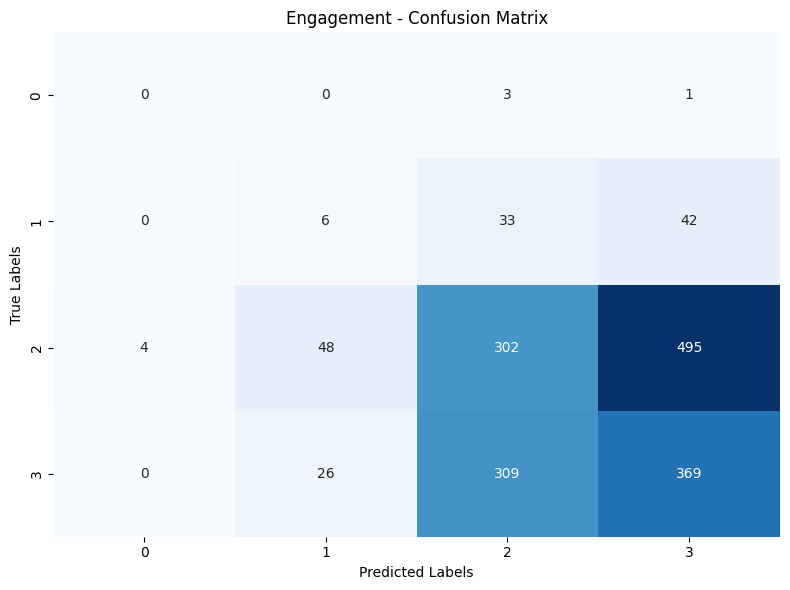

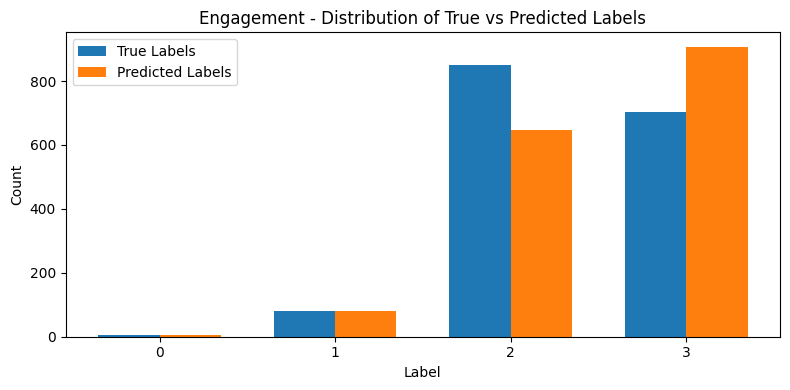


Evaluating model for Boredom...
Boredom validation accuracy: 0.3877

Classification Report:
              precision    recall  f1-score   support

           0     0.4987    0.4993    0.4990       747
           1     0.3487    0.3487    0.3487       519
           2     0.2395    0.2388    0.2392       335
           3     0.0270    0.0270    0.0270        37

    accuracy                         0.3877      1638
   macro avg     0.2785    0.2785    0.2785      1638
weighted avg     0.3875    0.3877    0.3876      1638

Confusion Matrix:
[[373 209 148  17]
 [229 181  95  14]
 [137 113  80   5]
 [  9  16  11   1]]


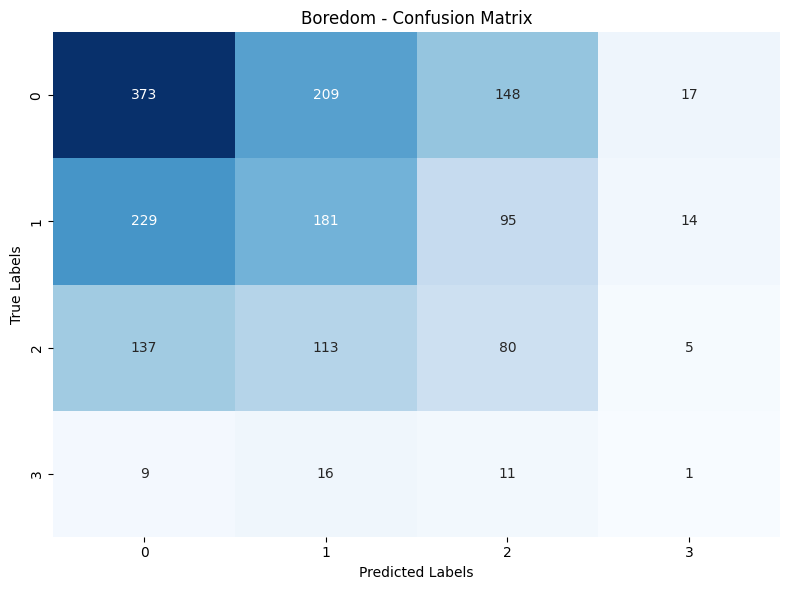

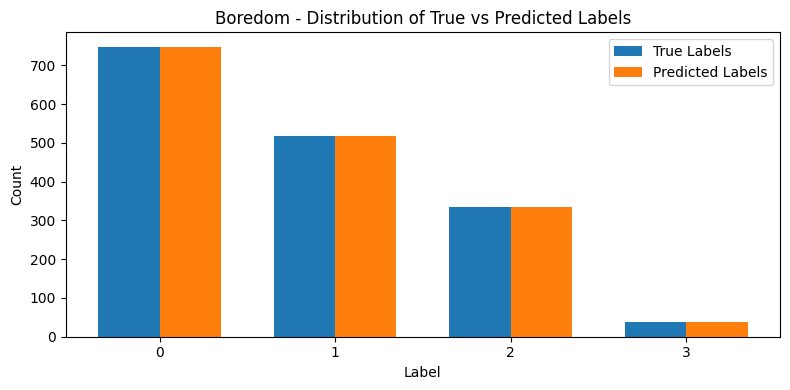


Evaluating model for Confusion...
Confusion validation accuracy: 0.5385

Classification Report:
              precision    recall  f1-score   support

           0     0.6960    0.6960    0.6960      1135
           1     0.2337    0.2337    0.2337       368
           2     0.0517    0.0517    0.0517       116
           3     0.0000    0.0000    0.0000        19

    accuracy                         0.5385      1638
   macro avg     0.2454    0.2454    0.2454      1638
weighted avg     0.5385    0.5385    0.5385      1638

Confusion Matrix:
[[790 252  80  13]
 [247  86  30   5]
 [ 82  27   6   1]
 [ 16   3   0   0]]


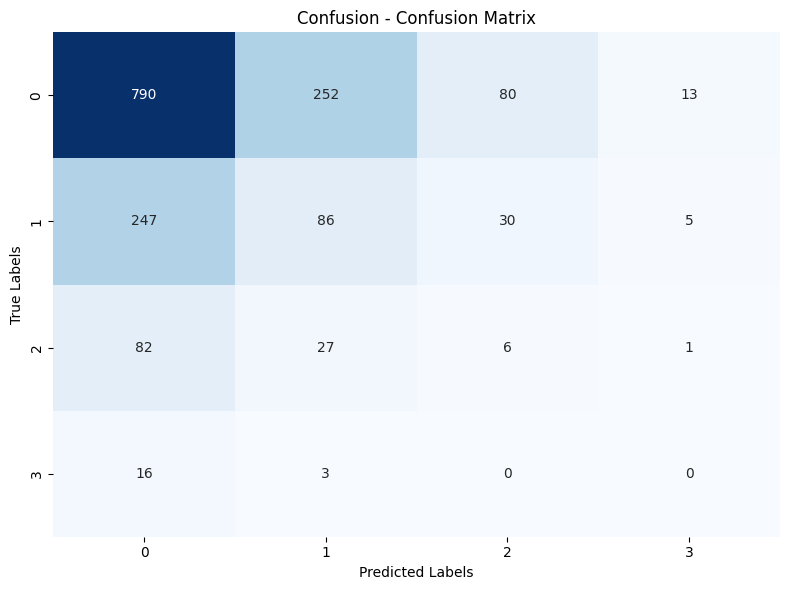

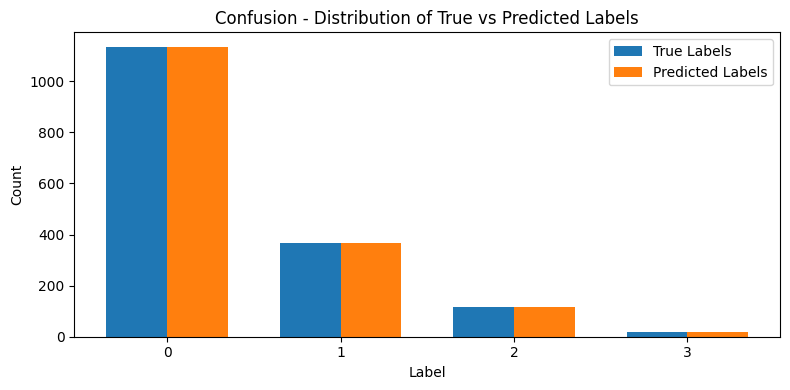


Evaluating model for Frustration...
Frustration validation accuracy: 0.6227

Classification Report:
              precision    recall  f1-score   support

           0     0.7670    0.7670    0.7670      1279
           1     0.1393    0.1393    0.1393       280
           2     0.0000    0.0000    0.0000        56
           3     0.0000    0.0000    0.0000        23

    accuracy                         0.6227      1638
   macro avg     0.2266    0.2266    0.2266      1638
weighted avg     0.6227    0.6227    0.6227      1638

Confusion Matrix:
[[981 233  46  19]
 [229  39   8   4]
 [ 48   7   0   1]
 [ 21   1   1   0]]


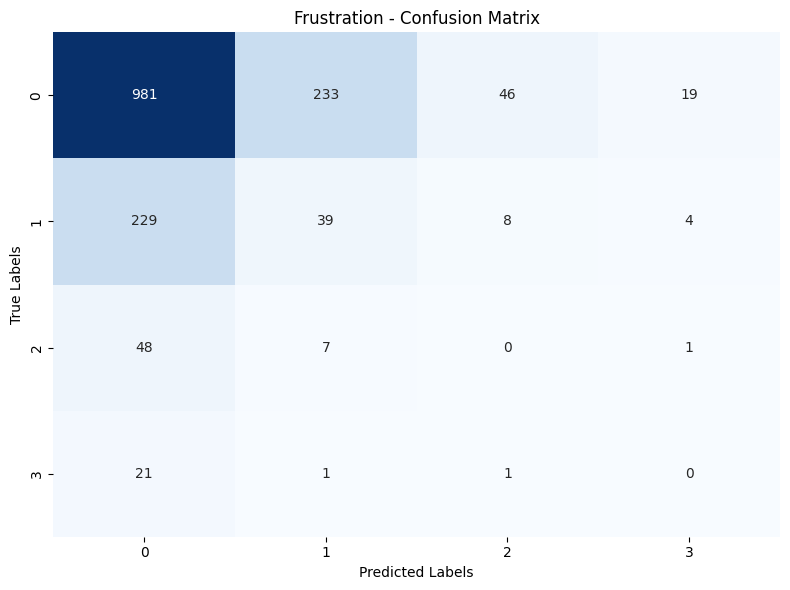

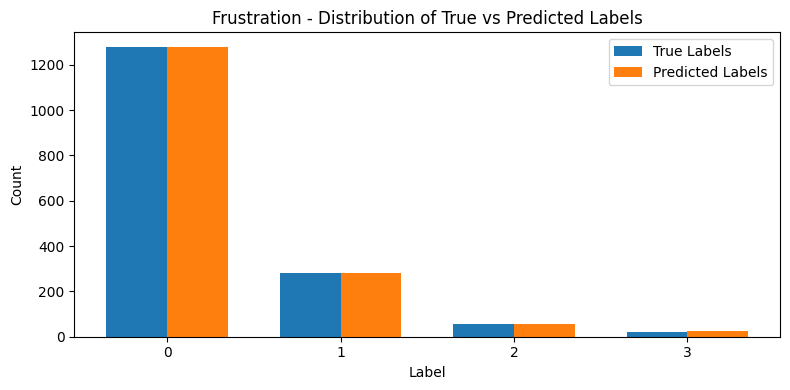


--- Performance Summary ---
Engagement: 0.4133
Boredom: 0.3877
Confusion: 0.5385
Frustration: 0.6227

--- Comparison vs XGBoost-HOG ---
Metric       MobileNet   XGBoost    Diff
------------------------------------------
Engagement   0.4133    0.5065    -0.0932
Boredom      0.3877    0.4711    -0.0834
Confusion    0.5385    0.6362    -0.0977
Frustration  0.6227    0.7444    -0.1217

--- Evaluation Complete ---


In [13]:
# Step 3: Final training with best hyperparameters and early stopping
final_checkpoint = MODEL_DIR / "final_model_checkpoint.pth"

if not final_checkpoint.exists():
    print("\n--- Starting Final Training ---")
    best_trial = study.best_trial
    params = best_trial.params

    num_frames = params.get("num_frames", 30)
    batch_size = params.get("batch_size", 8)
    lr = params.get("lr", 1e-4)
    epochs = params.get("epochs", 5)
    hidden_ch = params.get("hidden_ch", 128)
    freeze_block = params.get("freeze_block", 3)

    train_dataset = VideoDataset(train_csv, FRAMES_DIR, 
                                transform=train_transform, 
                                num_frames=num_frames)
    val_dataset = VideoDataset(val_csv, FRAMES_DIR,
                              transform=val_transform,
                              num_frames=num_frames)

    loader_args = {
        'batch_size': batch_size,
        'num_workers': 3,       # or 1
        'pin_memory': False,    # disable pinned memory on Windows
        'persistent_workers': False,
        'prefetch_factor': 2
    }

    train_loader = DataLoader(train_dataset, shuffle=True, **loader_args)
    val_loader = DataLoader(val_dataset, shuffle=False, **loader_args)

    final_model = MobileNetTCN(hidden_ch=hidden_ch, freeze_block=freeze_block)
    
    print(f"Training with: batch_size={batch_size}, lr={lr:.0e}, "
          f"hidden_ch={hidden_ch}, freeze_block={freeze_block}")
    try:
        train_model(final_model, train_loader, val_loader, 
                   epochs, lr, final_checkpoint, patience=5)
    except RuntimeError as e:
        print(f"Training failed: {e}")
        if final_checkpoint.exists():
            print("Partial checkpoint may exist")
            exit(1)
        if 'CUDA out of memory' in str(e):
            print("\nERROR: Insufficient GPU memory for final training!")
            print("Try reducing batch_size or hidden_ch in best parameters")
            exit(1)
        else:
            raise

    if not final_checkpoint.exists():
        print("ERROR: Final checkpoint not created after training!")
        exit(1)
else:
    print("\n--- Skipping Final Training (Checkpoint Exists) ---")
    print(f"Using existing model from: {final_checkpoint}")

print("\n--- Starting Evaluation ---")

if 'best_trial' not in locals():
    best_trial = study.best_trial
    params = best_trial.params
    num_frames = params.get("num_frames", 30)
    batch_size = params.get("batch_size", 8)
    hidden_ch = params.get("hidden_ch", 128)
    freeze_block = params.get("freeze_block", 3)
    epochs = params.get("epochs", 5)
    lr = params.get("lr", 0.00021151843688232635)

eval_model = MobileNetTCN(hidden_ch=hidden_ch, freeze_block=freeze_block)
if final_checkpoint.exists():
    state = torch.load(final_checkpoint, map_location=device)
    eval_model.load_state_dict(state['model_state_dict'])
else:
    raise FileNotFoundError(f"No checkpoint found at {final_checkpoint}")

eval_model.to(device)

test_csv = LABELS_DIR / "TestLabels.csv"
test_dataset = VideoDataset(test_csv, FRAMES_DIR,
                           transform=val_transform,
                           num_frames=num_frames)

test_loader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=0,
                        pin_memory=True,
                        persistent_workers=False)

try:
    evaluate_model(eval_model, test_loader)
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("\nERROR: Insufficient GPU memory for evaluation!")
        print("Try reducing batch_size for evaluation")
        exit(1)
    else:
        raise

torch.cuda.empty_cache()
gc.collect()
print("\n--- Evaluation Complete ---")